# Plot data in an automated way using cartopy

* Purpose of script: Create images to show the BWS variance over the year
* Author: Rutger Hofste
* Kernel used: python35 Cartopy
* Date created: 20171110

In [1]:
%matplotlib inline

In [2]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
print(sys.version)
%matplotlib inline

Y2017M11D10 UTC 17:50
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


## Settings

In [198]:
SCRIPT_NAME = "Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01"

INPUT_VERSION_TABLE = 6
INPUT_VERSION_SHAPE = 1

OUTPUT_VERSION = 1

S3_INPUT_PATH_TABLE = "s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/"
S3_INPUT_PATH_SHAPE = "s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Make_Geometry_Valid_V01/output/"
S3_OUTPUT_PATH = "s3://wri-projects/Aqueduct30/processData/%s/output/" %(SCRIPT_NAME)

EC2_INPUT_PATH = "/volumes/data/%s/input" %(SCRIPT_NAME)
EC2_OUTPUT_PATH = "/volumes/data/%s/output" %(SCRIPT_NAME)

INPUT_FILE_NAME_TABLE = "Y2017M10D04_RH_Threshold_WaterStress_V%0.2d" %(INPUT_VERSION_TABLE)
INPUT_FILE_NAME_SHAPE = "Y2017M11D10_RH_Make_Geometry_Valid_V%0.2d" %(INPUT_VERSION_SHAPE)

# Extent
x0 = -15
x1 = 10
y0 = 35
y1 = 45

COLUMN = "ws_s_year_Y2014"

In [58]:
!rm -r {EC2_INPUT_PATH} 
!rm -r {EC2_OUTPUT_PATH} 

In [59]:
!mkdir -p {EC2_INPUT_PATH} 
!mkdir -p {EC2_OUTPUT_PATH} 

In [60]:
!aws s3 cp {S3_INPUT_PATH_TABLE} {EC2_INPUT_PATH} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/Y2017M10D04_RH_Threshold_WaterStress_V05.pkl to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M10D04_RH_Threshold_WaterStress_V05.pkl
download: s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/Y2017M10D04_RH_Threshold_WaterStress_V06.pkl to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M10D04_RH_Threshold_WaterStress_V06.pkl
download: s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/Y2017M10D04_RH_Threshold_WaterStress_V05.csv to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M10D04_RH_Threshold_WaterStress_V05.csv
download: s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/Y2017M10D04_RH_Threshold_WaterStress_V06.csv to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M10D04_RH_Thresh

In [61]:
!aws s3 cp {S3_INPUT_PATH_SHAPE} {EC2_INPUT_PATH} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Make_Geometry_Valid_V01/output/Y2017M11D10_RH_Make_Geometry_Valid_V01.prj to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M11D10_RH_Make_Geometry_Valid_V01.prj
download: s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Make_Geometry_Valid_V01/output/Y2017M11D10_RH_Make_Geometry_Valid_V01.cpg to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M11D10_RH_Make_Geometry_Valid_V01.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Make_Geometry_Valid_V01/output/Y2017M11D10_RH_Make_Geometry_Valid_V01.shx to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M11D10_RH_Make_Geometry_Valid_V01.shx
download: s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Make_Geometry_Valid_V01/output/Y2017M11D10_RH_Make_Geometry_Valid_V01.dbf to ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/input/Y2017M11D10_RH_Make_Geometry_Valid_V01.dbf


In [238]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.geometry.collection import GeometryCollection
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature, Feature
from cartopy.io.img_tiles import StamenTerrain

In [234]:
categories = {0:{"Min":-9999,"Max":0,"Name":"Cat0","facecolor":"blue","edgecolor":"red","alpha":0.5},
              1:{"Min":0,"Max":1,"Name":"1) Low","facecolor":"#FFFF99","edgecolor":"black","alpha":0.5},
              2:{"Min":1,"Max":2,"Name":"2) Low to Medium","facecolor":"#FFE600","edgecolor":"black","alpha":0.5},
              3:{"Min":2,"Max":3,"Name":"3) Medium to high","facecolor":"#FF9900","edgecolor":"black","alpha":0.5},
              4:{"Min":3,"Max":4,"Name":"4) High ","facecolor":"#FF1900","edgecolor":"black","alpha":0.5},
              5:{"Min":4,"Max":5.01,"Name":"5) Extremely High ","facecolor":"#990000","edgecolor":"black","alpha":0.5},
              6:{"Min":5.01,"Max":9999,"Name":"Cat6","facecolor":"blue","edgecolor":"red","alpha":0.5}}

In [185]:
def createExtent(x0,x1,y0,y1):
    coords = [(x0,y0), (x1,y0), (x1, y1), (x0, y1)]
    extent = Polygon(coords)
    extentGdf = gpd.GeoDataFrame()
    extentGdf.loc[0, 'geometry'] = extent
    return extentGdf

def removeInvalid(gdf):
    gdf2 = gdf.copy()
    gdf2["isValid"] = gdf.geometry.is_valid
    gdfOut = gdf[gdf2['isValid']==True]
    return gdfOut

def categorizeBWS_s(value,column,categories):
    facecolor = "#ff66cc"
    edgecolor = "#ff66cc"
    alpha = 1
    
    for key, category in categories.items():
        if (value>= category["Min"]) and (value < category["Max"]):
            facecolor = category["facecolor"]
            edgecolor = category["edgecolor"]
            alpha = category["alpha"]
    
    return facecolor , edgecolor, alpha

def addFeatures(features):
    for item in features.records():
        attributes = item.attributes
        geometry = item.geometry
        facecolor , edgecolor, alpha = categorizeBWS_s(attributes,column,categories)        
        feature = ShapelyFeature(geometry,ccrs.PlateCarree(),facecolor=facecolor,edgecolor=edgecolor,alpha=alpha)
        ax.add_feature(feature)
    


In [64]:
df = pd.read_pickle(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME_TABLE+".pkl"))

In [69]:
gdf = gpd.read_file(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME_SHAPE+".shp"))

In [70]:
gdf = gdf.set_index("PFAF_ID", drop=False)

In [71]:
gdf2 = gdf.copy()

In [72]:
gdf3 = gdf2.loc[gdf2['PFAF_ID'].between(210000,220000)]

In [73]:
gdf4 = gdf2.loc[gdf2['PFAF_ID'].between(230000,240000)]

In [74]:
gdfRegion = gdf3.append(gdf4)

In [75]:
gdfRegionValid = removeInvalid(gdfRegion)

In [82]:
extentGdf = createExtent(x0,x1,y0,y1)

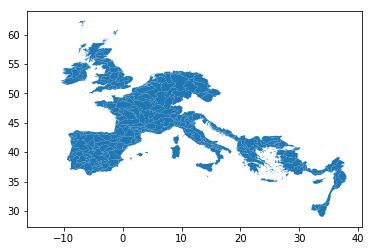

In [83]:
gdfRegionValid.plot()

In [95]:
gdf01 = gdfRegionValid.merge(df)

In [159]:
gdf01.dtypes

PFAF_ID                                    int64
type                                      object
geometry                                  object
HYBAS_ID2                                  int64
Unnamed: 0                                 int64
HYBAS_ID                                   int64
NEXT_DOWN                                  int64
NEXT_SINK                                  int64
MAIN_BAS                                   int64
DIST_SINK                                float64
DIST_MAIN                                float64
SUB_AREA                                 float64
UP_AREA                                  float64
ENDO                                       int64
COAST                                      int64
ORDER                                      int64
SORT                                       int64
Upstream_HYBAS_IDs                        object
Upstream_PFAF_IDs                         object
Downstream_HYBAS_IDs                      object
Downstream_PFAF_IDs 

Public read only key

1
2
3
4
5
6
7
8
9
10
11
12


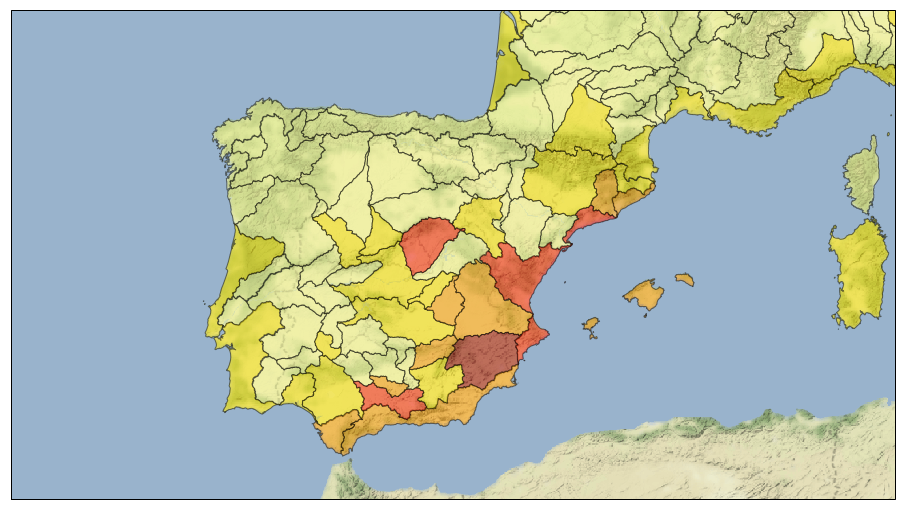

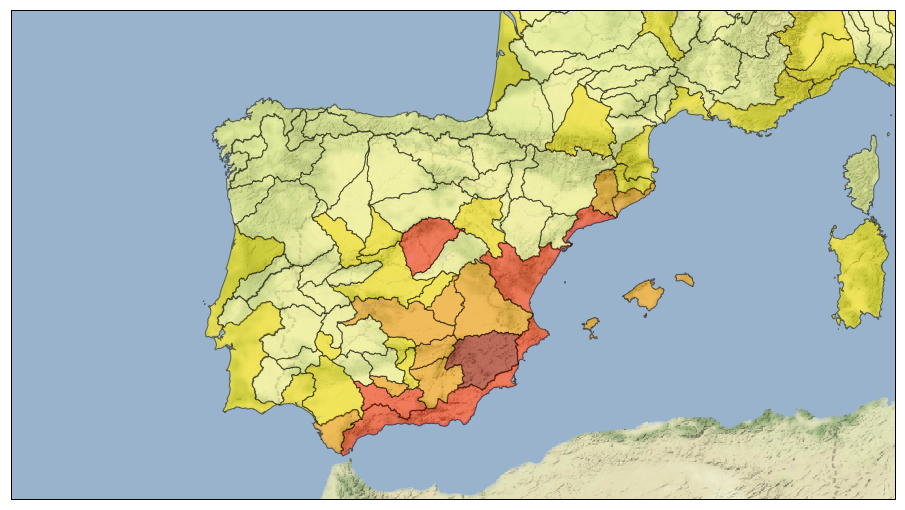

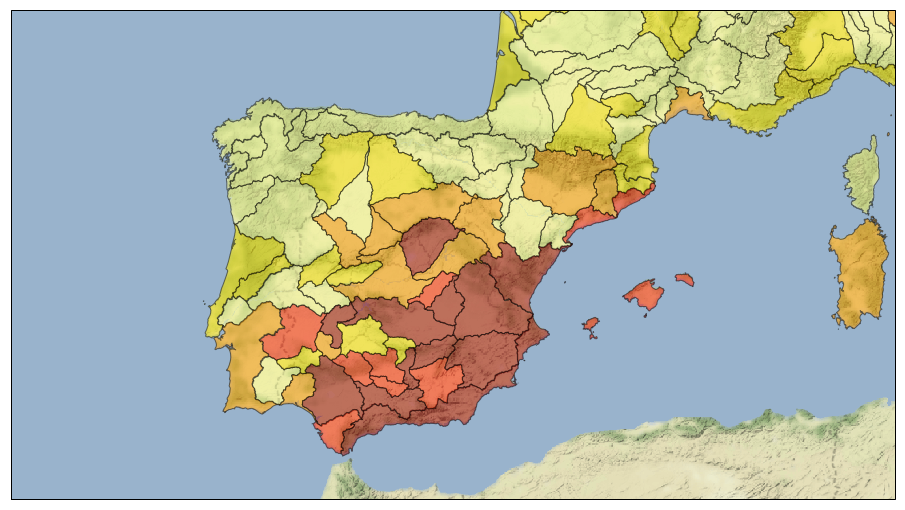

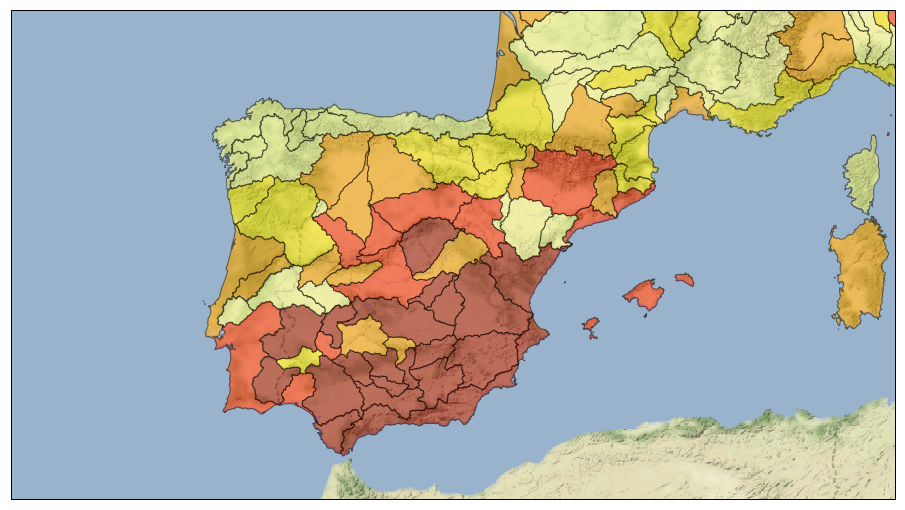

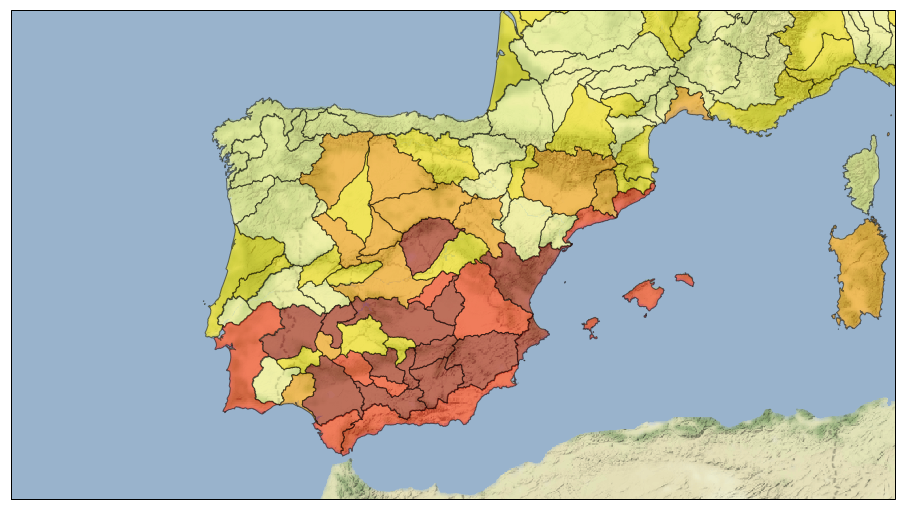

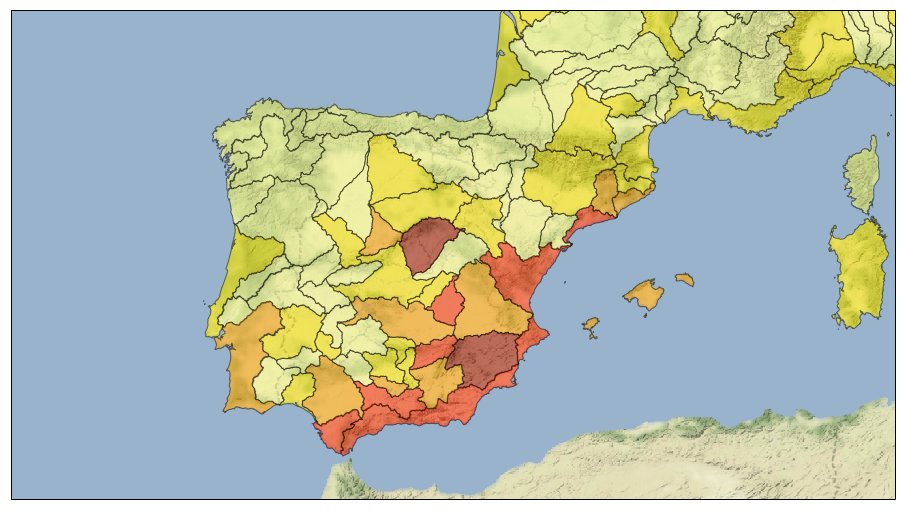

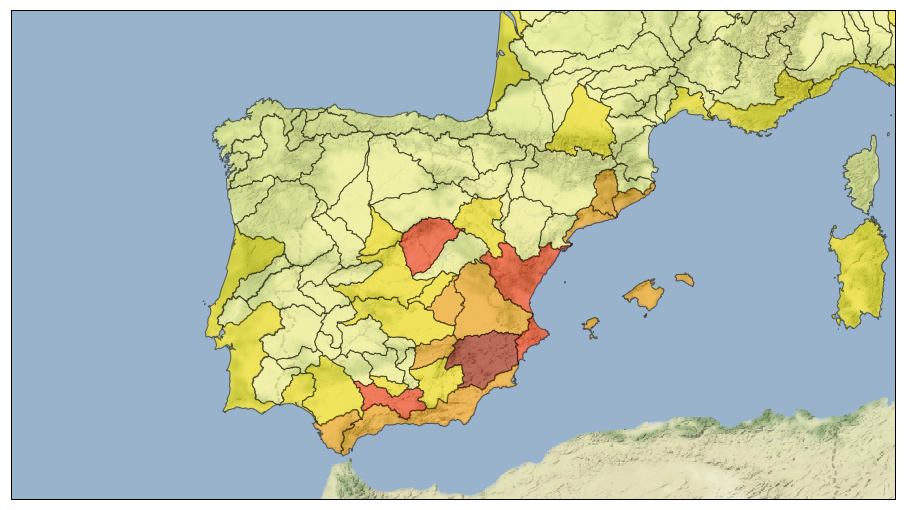

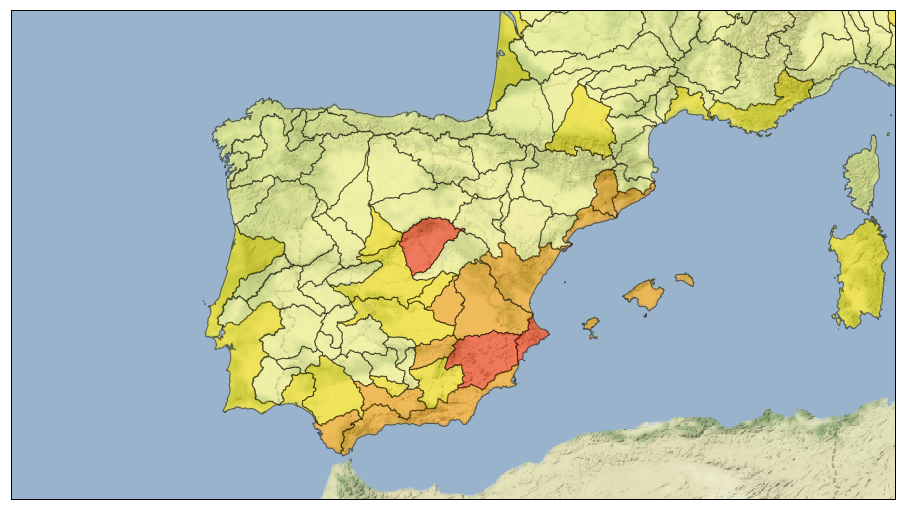

In [245]:
for month in range(1,13):
    print(month)
    column = "ws_s_month_Y2014M%02.d" %(month)
    outputFileName = "%sV%0.2d.png" %(column,OUTPUT_VERSION)
    outputFilePath = os.path.join(EC2_OUTPUT_PATH,outputFileName)
    
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection=ccrs.Mercator())
    extents = [x0,x1,y0,y1]
    ax.set_extent(extents, crs=None)
    #ax.coastlines(resolution='50m',alpha=1)

    
    tiler = StamenTerrain()
    mercator = tiler.crs
    ax.add_image(tiler, 6)
    
    ax.set_xmargin(0.00)
    ax.set_ymargin(0.00)
    
    for index, row in gdf01.iterrows():
        BWSvalue = row[column]
        facecolor , edgecolor, alpha = categorizeBWS_s(BWSvalue,COLUMN,categories)
        if row["aridAndLowWW_month_Y2014M%0.2d" %(month)]:
            facecolor = "#808080"
                
        feature = ShapelyFeature([row.geometry],ccrs.PlateCarree(),facecolor=facecolor,edgecolor=edgecolor,alpha=alpha)
        ax.add_feature(feature)
        
    plt.savefig(outputFilePath)
    

In [246]:
!aws s3 cp {EC2_OUTPUT_PATH} {S3_OUTPUT_PATH} --recursive

upload: ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M05V01.png to s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M05V01.png
upload: ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M06V01.png to s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M06V01.png
upload: ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M07V01.png to s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M07V01.png
upload: ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M04V01.png to s3://wri-projects/Aqueduct30/processData/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M04V01.png
upload: ../../../../data/Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01/output/ws_s_month_Y2014M08V01.png to s3://wri-projects/Aqu